In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('https://github.com/fadeeva/stock_market_research/raw/refs/heads/master/data/AAPL_2021-01-01_2022-12-31_1d.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-01-04,131.375674,131.464225,124.724238,127.331680,143301900,0.0,0.0
1,2021-01-05,126.820072,129.624308,126.367453,128.906021,97664900,0.0,0.0
2,2021-01-06,125.668842,128.945364,124.350358,124.566826,155088000,0.0,0.0
3,2021-01-07,126.298574,129.516063,125.806604,128.817459,109578200,0.0,0.0
4,2021-01-08,130.303162,130.499962,128.138498,129.929276,105158200,0.0,0.0


In [3]:
amd = pd.read_csv('https://github.com/fadeeva/stock_market_research/raw/refs/heads/master/data/AMD_2002-01-01_2022-12-31_1d.csv')
amd.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2001-12-31,16.490000,16.500000,15.850000,15.860000,3396500,0,0
1,2002-01-02,16.280001,16.410000,15.950000,16.389999,4475400,0,0
2,2002-01-03,16.719999,19.650000,16.719999,19.370001,14836600,0,0
3,2002-01-04,19.900000,20.200001,19.120001,20.000000,14737700,0,0
4,2002-01-07,20.450001,20.600000,19.530001,19.980000,9822300,0,0


In [4]:
prices = data['Close'].values.reshape(-1, 1)
amd_prices = amd['Close'].values.reshape(-1, 1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_prices = scaler.fit_transform(prices)
scaled_amd_prices = scaler.fit_transform(amd_prices)

In [6]:
# Создание последовательностей для обучения модели
def create_sequences(data: npt.NDArray, sequence_length:int)->npt.NDArray:
    sequences = []
    targets = []
    for i in range(len(data)-sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)

sequence_length = 60 # 60 дней
X, y = create_sequences(scaled_prices, sequence_length)

In [7]:
amd_X, amd_y = create_sequences(scaled_amd_prices, sequence_length)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
model = models.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(layers.LSTM(50, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, epochs=10,
                    validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.1467 - val_loss: 0.0098
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0230 - val_loss: 0.0211
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0110 - val_loss: 0.0168
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0094 - val_loss: 0.0127
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0079 - val_loss: 0.0096
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0083 - val_loss: 0.0139
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0075 - val_loss: 0.0115
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [13]:
amd_predictions = model.predict(amd_X)
amd_predictions = scaler.inverse_transform(amd_predictions)

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


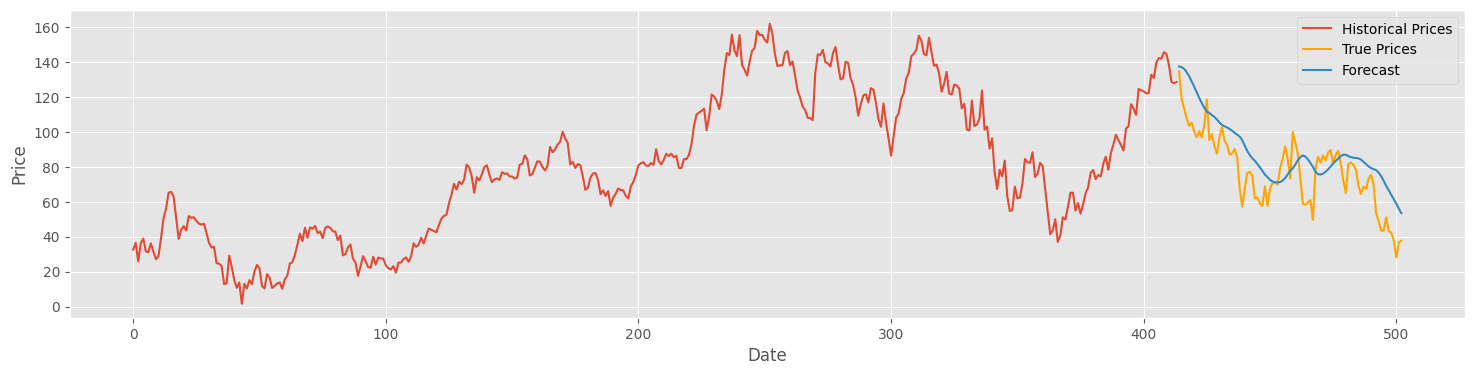

In [10]:
plt.figure(figsize=(18, 4))
plt.plot(data.index[:len(data)-len(y_test)],
         scaler.inverse_transform(scaled_prices[:len(scaled_prices)-len(y_test)]),
         label='Historical Prices')
plt.plot(data.index[len(data)-len(y_test):],
         scaler.inverse_transform(scaled_prices[len(scaled_prices)-len(y_test):]),
         color='orange', label='True Prices')
plt.plot(data.index[len(data)-len(y_test):], predictions, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

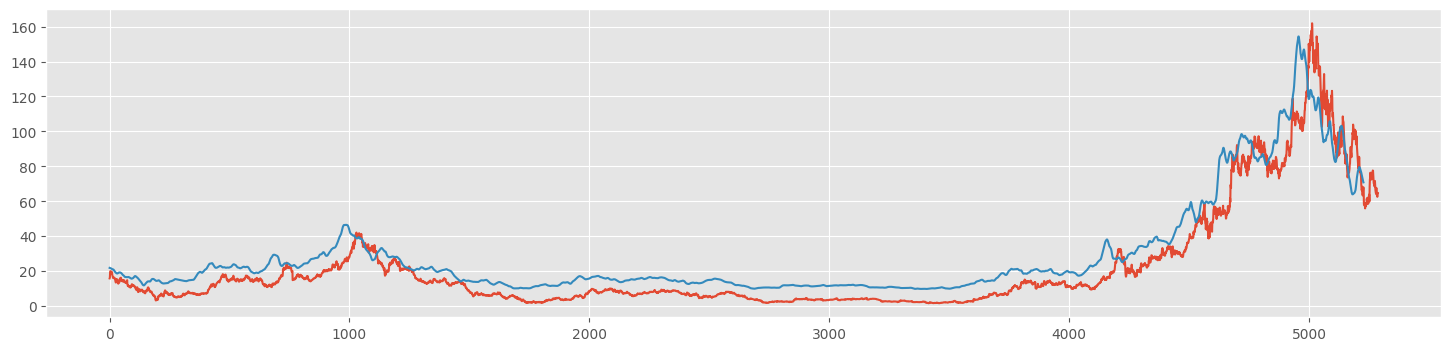

In [37]:
plt.figure(figsize=(18, 4))
plt.plot(amd.index, amd['Close'], label='')
plt.plot(amd.loc[:len(amd_X)-1].index, amd_predictions.reshape(-1), label='')
